In [254]:
import geopandas as gpd

In [255]:
import numpy as np

In [256]:
import pandas as pd

In [257]:
gdf = gpd.read_file('../data/AM24_MASTER/am24_subnat_em.shp')

In [258]:
df = gpd.read_file('../data/SPID_inequality/Data-Table 1.csv')

In [259]:
df2 = gpd.read_file(r'../data/SPID_mpm/Data-Table 1.csv')

In [252]:
data_keys = set(['mean2017', 'poor215','poor365', 'poor685', 'prosgap2017', 'gini', 'theil','lvlvar']+['dep_poor1', 'dep_educ_com', 'dep_educ_enr','dep_infra_elec', 'dep_infra_imps', 'dep_infra_impw2', 'mdpoor_i1'])

In [276]:
def get_distinguishing_keys(this_sub_df):
    return [ key for key in this_sub_df.keys() if 
            (this_sub_df[key].unique().shape[0] > 1)]

In [355]:
def reindex_duplicates_df(this_df):
    index_keys = ['code','geo_code','year','rep_year','lvlvar','data','data_group']
    this_df = this_df.set_index([
        key for key in index_keys if key in this_df.keys()
    ]).sort_index().copy()
    this_df.sort_index()
    
    this_df['child_index'] = 0
    
    for group,data in this_df.groupby(this_df.index):
        if data.shape[0] > 1: 
            add_child_indices(this_df,group,data)
            distinguishing_keys = get_distinguishing_keys(data)
            print(distinguishing_keys)
    

    return this_df#this_df.set_index('child_index',append=True)

def add_child_indices(this_df, group, this_sub_df):
    validate_selection(this_df,group,this_sub_df)
    this_df.loc[group,'child_index'] = np.arange(this_sub_df.shape[0])

def validate_selection(this_df,group,this_sub_df):
    if not np.all(this_df.loc[group] == this_sub_df):
        raise Exception("BAD")

In [356]:
foo = reindex_duplicates_df(df)
bar = reindex_duplicates_df(df2)

['lvlvar', 'byvar', 'geo_code2_new']
['lvlvar', 'geo_code2_new']
['lvlvar', 'geo_code2_new']
['lvlvar', 'geo_code2_new']
['lvlvar', 'geo_code2_new']
['lvlvar', 'geo_code2_new']
['lvlvar', 'geo_code2_new']
['lvlvar', 'byvar', 'geo_code2_new']
['lvlvar', 'geo_code2_new']
['lvlvar', 'geo_code2_new']
['lvlvar', 'geo_code2_new']
['lvlvar', 'geo_code2_new']
['lvlvar', 'geo_code2_new']
['lvlvar', 'geo_code2_new']
['lvlvar', 'byvar', 'geo_code2_new']
['lvlvar', 'geo_code2_new']
['lvlvar', 'geo_code2_new']
['lvlvar', 'geo_code2_new']
['lvlvar', 'geo_code2_new']
['lvlvar', 'geo_code2_new']
['lvlvar', 'geo_code2_new']
['lvlvar', 'byvar', 'geo_code2_new']
['lvlvar', 'geo_code2_new']
['lvlvar', 'geo_code2_new']
['lvlvar', 'geo_code2_new']
['lvlvar', 'geo_code2_new']
['lvlvar', 'geo_code2_new']
['lvlvar', 'geo_code2_new']
['lvlvar', 'byvar', 'geo_code2_new']
['lvlvar', 'geo_code2_new']
['lvlvar', 'geo_code2_new']
['lvlvar', 'geo_code2_new']
['lvlvar', 'geo_code2_new']
['lvlvar', 'geo_code2_new']
['l

In [357]:
print(foo.index.names)
print(bar.index.names)

['code', 'geo_code', 'year', 'rep_year', 'survname', 'data', 'data_group']
['code', 'geo_code', 'year', 'rep_year', 'survname']


In [358]:
bar_geo_codes = set(bar.index.get_level_values('geo_code'))
for geo_code in foo.index.get_level_values('geo_code').unique():
    if geo_code in bar_geo_codes:
        break

In [354]:
foo[foo.index.get_level_values('data') == 'ALL']

survname  \
code geo_code             year rep_year lvlvar    data data_group              
AGO  AGO_2015_GAUL1_398   2008 2008     subnatid2 ALL  ALL         IBEP-MICS   
                          2018 2018     subnatid  ALL  ALL             IDREA   
     AGO_2015_GAUL1_399   2008 2008     subnatid2 ALL  ALL         IBEP-MICS   
                          2018 2018     subnatid  ALL  ALL             IDREA   
     AGO_2015_GAUL1_400   2008 2008     subnatid2 ALL  ALL         IBEP-MICS   
...                                                                      ...   
ZWE  ZWE_2015_GAUL1_3444  2019 2019     subnatid1 ALL  ALL             PICES   
     ZWE_2015_GAUL1_69549 2017 2017     subnatid  ALL  ALL             PICES   
                          2019 2019     subnatid1 ALL  ALL             PICES   
     ZWE_2015_GAUL1_69550 2017 2017     subnatid  ALL  ALL             PICES   
                          2019 2019     subnatid1 ALL  ALL             PICES   

                                                                       byvar  \
code geo_code             year rep_year lvlvar    data data_group              
AGO  AGO_2015_GAUL1_398   2008 2008     subnatid2 ALL  ALL         subnatid2   
                          2018 2018     subnatid  ALL  ALL          subnatid   
     AGO_2015_GAUL1_399   2008 2008     subnatid2 ALL  ALL         subnatid2   
                          2018 2018     subnatid  ALL  ALL          subnatid   
     AGO_2015_GAUL1_400   2008 2008     subnatid2 ALL  ALL         subnatid2   
...                                                                      ...   
ZWE  ZWE_2015_GAUL1_3444  2019 2019     subnatid1 ALL  ALL         subnatid1   
     ZWE_2015_GAUL1_69549 2017 2017     subnatid  ALL  ALL          subnatid   
                          2019 2019     subnatid1 ALL  ALL         subnatid1   
     ZWE_2015_GAUL1_69550 2017 2017     subnatid  ALL  ALL          subnatid   
                          2019 2019     subnatid1 ALL  ALL         subnatid1   

                                                                     vintage  \
code geo_code             year rep_year lvlvar    data data_group              
AGO  AGO_2015_GAUL1_398   2008 2008     subnatid2 ALL  ALL         Fall 2024   
                          2018 2018     subnatid  ALL  ALL         Fall 2024   
     AGO_2015_GAUL1_399   2008 2008     subnatid2 ALL  ALL         Fall 2024   
                          2018 2018     subnatid  ALL  ALL         Fall 2024   
     AGO_2015_GAUL1_400   2008 2008     subnatid2 ALL  ALL         Fall 2024   
...                                                                      ...   
ZWE  ZWE_2015_GAUL1_3444  2019 2019     subnatid1 ALL  ALL         Fall 2024   
     ZWE_2015_GAUL1_69549 2017 2017     subnatid  ALL  ALL         Fall 2024   
                          2019 2019     subnatid1 ALL  ALL         Fall 2024   
     ZWE_2015_GAUL1_69550 2017 2017     subnatid  ALL  ALL         Fall 2024   
                          2019 2019     subnatid1 ALL  ALL         Fall 2024   

                                                                               sample  \
code geo_code             year rep_year lvlvar    data data_group                       
AGO  AGO_2015_GAUL1_398   2008 2008     subnatid2 ALL  ALL                      Bengo   
                          2018 2018     subnatid  ALL  ALL                      Bengo   
     AGO_2015_GAUL1_399   2008 2008     subnatid2 ALL  ALL                   Benguela   
                          2018 2018     subnatid  ALL  ALL                   Benguela   
     AGO_2015_GAUL1_400   2008 2008     subnatid2 ALL  ALL                        Bie   
...                                                                               ...   
ZWE  ZWE_2015_GAUL1_3444  2019 2019     subnatid1 ALL  ALL                   Midlands   
     ZWE_2015_GAUL1_69549 2017 2017     subnatid  ALL  ALL         Matabeleland North   
                          2019 2019     subnatid1 ALL  

In [334]:
bar[bar.index.get_level_values('geo_code') == 'BTN_2015_GAUL1_41308']

code survname    vintage  sample  \
geo_code             year ref_year                                    
BTN_2015_GAUL1_41308 2017 2017      BTN     BLSS  Fall 2024  Dagana   
                     2022 2022      BTN     BLSS  Fall 2024  Dagana   

                                   survey_coverage welfaretype rep_year  \
geo_code             year ref_year                                        
BTN_2015_GAUL1_41308 2017 2017                   N        CONS     2017   
                     2022 2022                   N        CONS     2022   

                                   comparability  dep_poor1 dep_educ_com  \
geo_code             year ref_year                                         
BTN_2015_GAUL1_41308 2017 2017                 1  0.0816817    0.5404838   
                     2022 2022                 2          0    0.3046392   

                                   dep_educ_enr dep_infra_elec dep_infra_imps  \
geo_code             year ref_year                                              
BTN_2015_GAUL1_41308 2017 2017        0.0321142              0      0.1363102   
                     2022 2022        0.0361007      0.0026031      0.0368593   

                                   dep_infra_impw2  mdpoor_i1 geometry  \
geo_code             year ref_year                                       
BTN_2015_GAUL1_41308 2017 2017                   0  0.1012294     None   
                     2022 2022                   0  0.0122731     None   

                                    child_index  
geo_code             year ref_year               
BTN_2015_GAUL1_41308 2017 2017                0  
                     2022 2022                0

In [318]:
foo.index.intersection(bar.index)

MultiIndex([], names=['comparability', 'geo_code', 'year', None, None, None])

In [311]:
bar.loc['0'].loc['BRA_2015_GAUL1_665']

KeyError: 'BRA_2015_GAUL1_665'

In [306]:
foo.loc[[bar.index[0]]

KeyError: "None of [Index([('', 'HRV_2006_NUTS2_HR01', '2010'), Ellipsis], dtype='object')] are in the [index]"

In [299]:
foo.head()

code  \
comparability geo_code           year lvlvar    byvar      data_group        
0             BRA_2015_GAUL1_665 2001 subnatid2 reg_agegr3 0-5         BRA   
                                                           11-Jun      BRA   
                                                           17+         BRA   
                                                           17-Dec      BRA   
                                                reg_gender FEMALE      BRA   

                                                                      rep_year  \
comparability geo_code           year lvlvar    byvar      data_group            
0             BRA_2015_GAUL1_665 2001 subnatid2 reg_agegr3 0-5            2001   
                                                           11-Jun         2001   
                                                           17+            2001   
                                                           17-Dec         2001   
                                                reg_gender FEMALE         2001   

                                                                      survname  \
comparability geo_code           year lvlvar    byvar      data_group            
0             BRA_2015_GAUL1_665 2001 subnatid2 reg_agegr3 0-5            PNAD   
                                                           11-Jun         PNAD   
                                                           17+            PNAD   
                                                           17-Dec         PNAD   
                                                reg_gender FEMALE         PNAD   

                                                                            data  \
comparability geo_code           year lvlvar    byvar      data_group              
0             BRA_2015_GAUL1_665 2001 subnatid2 reg_agegr3 0-5         agegroup3   
                                                           11-Jun      agegroup3   
                                                           17+         agegroup3   
                                                           17-Dec      agegroup3   
                                                reg_gender FEMALE         Gender   

                                                                         vintage  \
comparability geo_code           year lvlvar    byvar      data_group              
0             BRA_2015_GAUL1_665 2001 subnatid2 reg_agegr3 0-5         Fall 2024   
                                                           11-Jun      Fall 2024   
                                                           17+         Fall 2024   
                                                           17-Dec      Fall 2024   
                                                reg_gender FEMALE      Fall 2024   

                                                                      sample  \
comparability geo_code           year lvlvar    byvar      data_group          
0             BRA_2015_GAUL1_665 2001 subnatid2 reg_agegr3 0-5          Acre   
                                                           11-Jun       Acre   
                                                           17+          Acre   
                                                           17-Dec       Acre   
                                                reg_gender FEMALE       Acre   

                                                                                link  \
comparability geo_code           year lvlvar    byvar      data_group                  
0             BRA_2015_GAUL1_665 2001 subnatid2 reg_agegr3 0-5         BRA_2001_PNAD   
                                                           11-Jun      BRA_2001_PNAD   
                                                           17+         BRA_2001_PNAD   
                                                           17-Dec      BRA_2001_PNAD   
                                                reg_gender FEMALE      BRA_2001_PNAD   

                 

In [159]:
comparability_values = merged_df.index.get_level_values('comparability') 
for cv in comparability_values.unique():
    mask = comparability_values == cv
    sub_df = merged_df[mask]
    child_indices = sub_df.index.get_level_values('child_index')
    the_index = child_indices.unique()[-1]
    if the_index > 0:
        mask = child_indices == the_index
        print('the index:',the_index)
        print(sub_df[mask].head())
    
    print(cv,sub_df.shape)
    

 (17, 17)
the index: 97
                                                mean2017     poor215  \
comparability geo_code            child_index                          
0             MEX_2015_GAUL1_2028 97           16.093923  0.01528448   
              MEX_2015_GAUL1_2029 97           19.076185  0.00159352   
              MEX_2015_GAUL1_2030 97           18.333718  0.01076782   
              MEX_2015_GAUL1_2031 97           16.050998  0.03496482   
              MEX_2015_GAUL1_2032 97           7.7517187  0.16734783   

                                                  poor365     poor685  \
comparability geo_code            child_index                           
0             MEX_2015_GAUL1_2028 97           0.05995914  0.28378005   
              MEX_2015_GAUL1_2029 97           0.03359216  0.18508167   
              MEX_2015_GAUL1_2030 97           0.03026898  0.16164155   
              MEX_2015_GAUL1_2031 97           0.12472535  0.36128547   
              MEX_2015_GAUL1_2032

In [ ]:
# Select rows based on a condition on the first index level
mask = merged_df.index.get_level_values(0) == '0'
selected_data = merged_df[mask]

In [31]:
# Merge ineq_df and mpm_df on 'geo_code'
merged_df = pd.merge(ineq_df, mpm_df, on='geo_code', how='inner')

# Merge the result with geo_gdf on 'geo_code'
final_gdf = gpd.GeoDataFrame(pd.merge(merged_df, geo_gdf, on='geo_code', how='inner'))

# Ensure the geometry column is properly recognized
final_gdf.set_geometry('geometry', inplace=True)

In [103]:
final_gdf.shape

(360658, 21)

<Axes: >

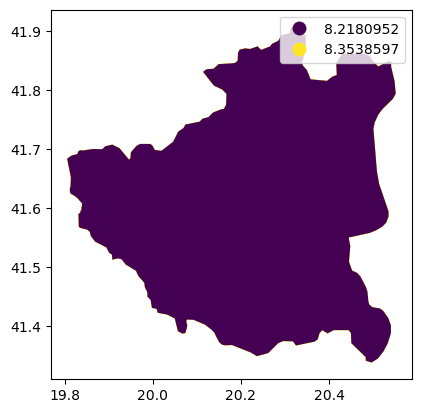

In [39]:
final_gdf.head().plot(column='mean2017',cmap='viridis',legend=True)

/opt/homebrew/Caskroom/miniconda/base/envs/python310/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


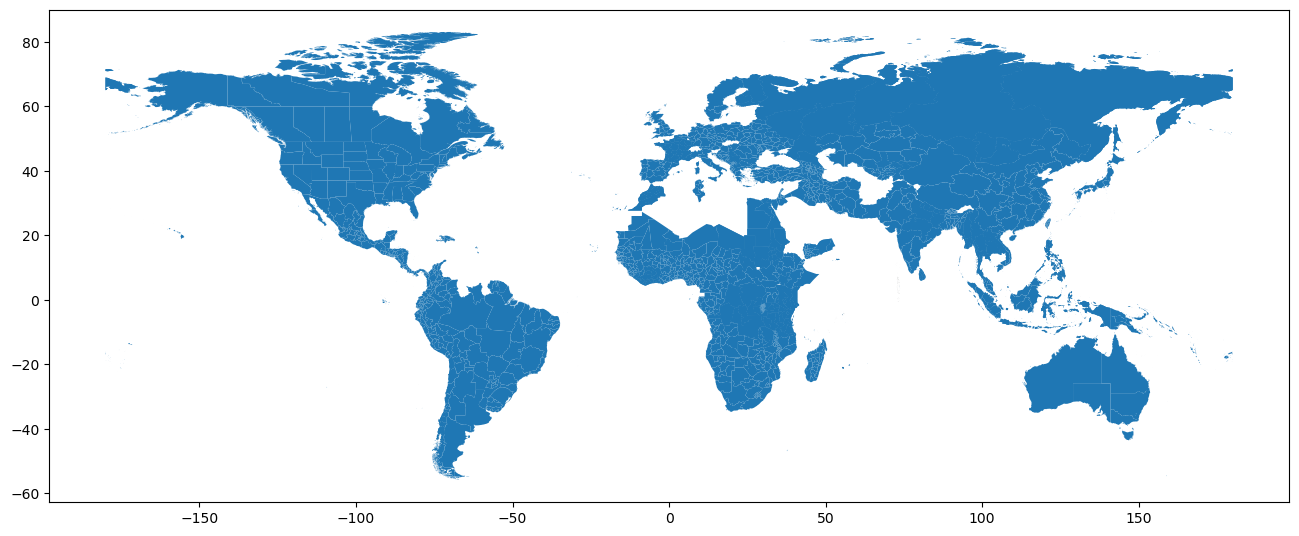

In [4]:
ax = gdf.plot()

ax.get_figure().set_size_inches(16,8)


In [5]:
gdf.keys()

Index(['code', 'geo_year', 'geo_source', 'geo_level', 'geo_idvar', 'geo_id',
       'geo_nvar', 'geo_name', 'geo_code', 'geometry'],
      dtype='object')

In [6]:
gdf['geo_level'].unique()

array(['1', '3', 'x', '2', '0'], dtype=object)

/opt/homebrew/Caskroom/miniconda/base/envs/python310/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<Axes: >

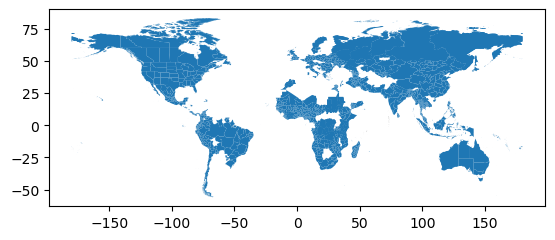

In [13]:
gdf[gdf.geo_level == '1'].plot()

In [15]:
gdf.head()

,code,geo_year,geo_source,geo_level,geo_idvar,geo_id,geo_nvar,geo_name,geo_code,geometry
0,AGO,2015.0,GAUL,1,ADM1_CODE,398,ADM1_NAME,Bengo,AGO_2015_GAUL1_398,"POLYGON ((13.14401 -9.33313, 13.14405 -9.33316..."
1,AGO,2015.0,GAUL,1,ADM1_CODE,399,ADM1_NAME,Benguela,AGO_2015_GAUL1_399,"POLYGON ((13.79886 -11.77102, 13.79883 -11.771..."
2,AGO,2015.0,GAUL,1,ADM1_CODE,400,ADM1_NAME,Bie,AGO_2015_GAUL1_400,"POLYGON ((16.79741 -10.77021, 16.80907 -10.772..."
3,AGO,2015.0,GAUL,1,ADM1_CODE,401,ADM1_NAME,Cabinda,AGO_2015_GAUL1_401,"POLYGON ((13.06533 -4.66395, 13.02957 -4.67687..."
4,AGO,2015.0,GAUL,1,ADM1_CODE,402,ADM1_NAME,Cuando Cubango,AGO_2015_GAUL1_402,"POLYGON ((17.27483 -17.38822, 17.27519 -17.388..."
